# Reddit Social Network Analysis of Influential Users and Subreddits

## Name: Soumyadeepta Das
## Reg. No: 18BCE1350
## Subject: Social Information Networks

### Importing Libraries

In [3]:
import praw
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In C:\ANaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ANaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ANaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ANaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ANaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was deprecated in Matplo

### function to hide the next cell(utility) containing credntials

In [4]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

### initialising Praw instance

In [5]:
# Authentication 
reddit = praw.Reddit(client_id='',
                     client_secret='',
                     user_agent='',
                     username='',
                     password='')
hide_toggle()

### Defining functions for future data scraping (utility functions)

#### gets n posts of the given subreddit and returns a df containing, id, score, author, num of comments and the subreddit it belongs to

In [4]:
def get_posts(sub_name, n):
    subreddit = reddit.subreddit(sub_name)
    posts_list = [] 
    
    for submission in subreddit.top(limit=n):
        info_list = []
        info_list.append(submission.id)   # Output: the submission's title
        info_list.append(submission.score)  # Output: the submission's score  
        info_list.append(str(submission.author)) 
        info_list.append(submission.num_comments)
        info_list.append(submission.subreddit)
        posts_list.append(info_list)
    
    a = sorted(posts_list, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(a, columns = ['id', 'score', 'author', 'num_comments', 'subreddit'])
    return posts_df

#### gets n comments of the given submission/post using an id and returns the list of comments with id, score, author and subreddit

In [5]:
def get_comments(subm_id, n): 
    
    com_list = []
    submission = reddit.submission(id = subm_id)
    i = 0
    for comment in submission.comments:
        info_list = []
            # Top 3 comments for each submission
        if i <= n:
            info_list.append(comment.id)
            info_list.append(comment.score)
            info_list.append(comment.author)
            info_list.append(submission.subreddit)
            #info_list.append(submission.comments.list()[i].body)
            i += 1
            com_list.append(info_list)
        else:
            break
    
    a = sorted(com_list, key=lambda x: x[1], reverse = True)
    com_df = pd.DataFrame(a)
    return com_df   

#### get top n posts of a particular given user nad returns a list containing each posts is, score, author, num of comments and subreddit

In [6]:
def get_user_posts(author, n):
    
    redditor = reddit.redditor(author)
    user_posts_list = []
    
    for submission in redditor.submissions.top(limit = n):
        info_list = []
        info_list.append(submission.id)
        info_list.append(submission.score)
        info_list.append(str(submission.author))
        info_list.append(submission.num_comments)
        info_list.append(str(submission.subreddit))
        user_posts_list.append(info_list)
    
    a = sorted(user_posts_list, key=lambda x: x[1], reverse = True)
    user_posts_df = pd.DataFrame(a)
    return user_posts_df 

# Initial Analysis of r/all

## fetching 1000 posts from all subreddits, and storing in  a dataframe with details as below

In [7]:
df = get_posts('all', 1000)

#### 945 posts from all subreddits with 5 data columns

In [9]:
df.shape # Explore posts dataframe

(945, 5)

In [10]:
df.head(10)

id   score             author  num_comments  subreddit
0  5gn8ru  283479            iH8myPP          5017      funny
1  5bx4bx  230837  Itsjorgehernandez          6113       pics
2  5sfexx  222807          datbanter          4368       pics
3   z1c9z  216152     PresidentObama         23200       IAmA
4  5jrlw1  204191          iswearidk          5668       gifs
5  5y51v9  168686         BigCballer          1322      funny
6  5by1wy  163307             Zykium          8732       pics
7  5pqxdk  157909         GallowBoob          5320       pics
8  4d75i7  154761       mister_geaux         12222  worldnews
9  5fk6rm  142160           spitonem          2088       gifs

#### 770 uniquue author for the above 945 posts are there

In [12]:
df.author.nunique()

770

#### 945 fetched posts are from 52 unique subreddits

In [13]:
df.subreddit.nunique()

52

#### min score of the posts fetched is 59740 and max is 283486, with mean score 76176 and 75% score below 80760

In [14]:
df['score'].describe()

count       945.000000
mean      76176.911111
std       19829.558195
min       59740.000000
25%       64294.000000
50%       70596.000000
75%       80760.000000
max      283486.000000
Name: score, dtype: float64

#### min num_comments in the fetched posts are 355 and max is 80407 with mean num of comments 3242, and 75% of num of comments being under 3495

In [15]:
df['num_comments'].describe()

count      945.000000
mean      3242.501587
std       4635.728545
min        355.000000
25%       1227.000000
50%       2051.000000
75%       3495.000000
max      80407.000000
Name: num_comments, dtype: float64

# Analysis based on particular subreddit r/marvelstudios

In [16]:
import matplotlib.pyplot as plt

### fetching 500 posts from subreddit "marvelstudios"

In [8]:
marvel_df = get_posts('marvelstudios', 500) 

### 434 unique authors in the 500 fetched posts

In [9]:
marvel_df.author.nunique() # Out of 500, 434 are unique 

434

### plotting number of comments vs score, we see that they are almost directly proportional, for this subreddit
#### posts with more num of comments have more score in general

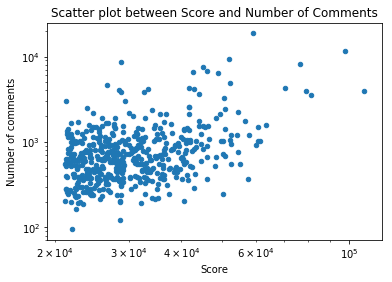

In [39]:
# See the relationship between comments and upvotes 
ax = marvel_df.plot('score', 'num_comments', kind = 'scatter',logx=True, logy=True, title='Scatter plot between Score and Number of Comments')
ax.set(xlabel="Score", ylabel="Number of comments")
plt.savefig("ScatterPlot",dpi=150, bbox_inches='tight',pad_inches=0.5)

### we are separating influencers based on condition that they should be active and they should have more than one post in a particular subreddit

In [40]:
repeating = marvel_df[marvel_df.duplicated(['author'], keep = False)] # Only taking users who posted more than once

In [41]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

### after above selection 38 influencers were selected for the subreddit "marvelstudios", from the total of 434 users

In [42]:
repeating.author.nunique() # Out of 500 posts, this is the amount of people who posted more than once 

38

### distribution of influencers and their number of postsfor this subreddit

In [45]:
#  distrubution of authors and their posts
ax = repeating.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")
plt.savefig("Bargraph",dpi=150, bbox_inches='tight',pad_inches=0.5)

In [47]:
# Compiling a list of authors that appeared more than once on subreddit's top of all times 
# (Used for network graph and for get_user_posts function)
u_authors = list(repeating.author.unique()) 

## for each influencer as above, we are collecting 10 top posts of their account

In [48]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df = pd.concat([authors_df, c]) 

In [49]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

### below data frame shows the head of df which stores top 10 posts of the influencers
#### in the first 10 rows it stores posts of author "Zosodechaine", and we see they post in subreddits like "marvelstudios","StarWars","gaming","The LastAirBender"

In [50]:
authors_df.head(10) # Dataframe of other subreddits where authors posted 

id  score        author  num_comments         subreddit
0  935qhl  76609  Zosodechaine          8100     marvelstudios
1  b4jgjw  30617  Zosodechaine          2034     marvelstudios
2  96ysua  29234  Zosodechaine          1037     marvelstudios
3  8jofyx  15977  Zosodechaine           170          StarWars
4  bui98o   5025  Zosodechaine           260            gaming
5  9hafcu   2080  Zosodechaine           106  TheLastAirbender
6  9uh5ah   1815  Zosodechaine            24     marvelstudios
7  bldqt2   1716  Zosodechaine            19     marvelstudios
8  bz74xl   1704  Zosodechaine            93     marvelstudios
9  a1tm33   1302  Zosodechaine            95     marvelstudios

## from the above data frame, we plot the popular subreddits among the influencers

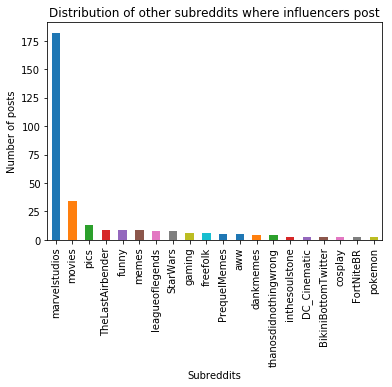

In [52]:
counts = authors_df['subreddit'].value_counts() 
# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

# Network Analysis

## Initial approach

#### df of authors and subreddits

In [53]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

author      subreddit
0  Zosodechaine  marvelstudios
1  Zosodechaine  marvelstudios
2  Zosodechaine  marvelstudios
3  Zosodechaine       StarWars
4  Zosodechaine         gaming

#### graph using nx, but is crude

In [54]:
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') # Initial ugly approach, decided to keep it
nx.draw(g)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


## Final Approach

In [55]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph 

# Influencers appear small and yellow
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY

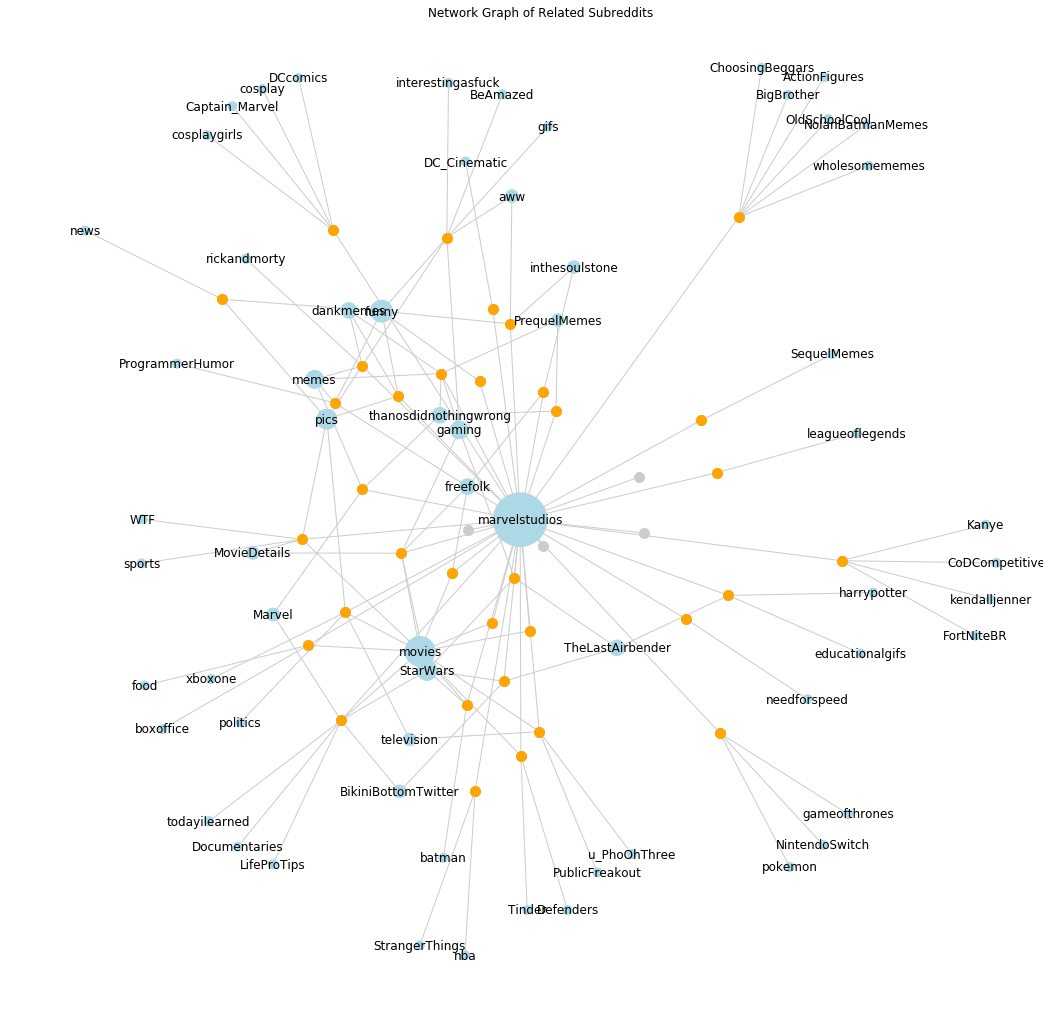

In [65]:
plt.figure(figsize=(18, 18))

# Creating the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Creating a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)


# For every subbreddit, checking the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Drawing all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=u_authors, node_color='#cccccc', node_size=100)

# Drawing highly connected influencers 
popular_people = [person for person in u_authors if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
nx.draw_networkx_labels(g, layout, labels=node_labels)

# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.5)
plt.show()

In [66]:
g.degree('movies') # To check the number of out-degrees for a subreddit

11